In [0]:
# This notebook processes Amazon review data using Spark on Databricks. It performs the following operations:
# 1. Data Ingestion: Loads Amazon review and metadata JSONL files
# 2. Data Cleaning: Handles missing values, duplicates, timestamp issues, and outliers

# 3. Join Operations: Combines reviews with product metadata
# 4. Data Transformation: Converts categorical values to numerical
# 5. Exploratory Data Analysis (EDA): Computes summary statistics, generates visualizations, and extracts insights
# 6. Output: Saves processed data in a structured format

In [0]:
## 1. Environment Setup and Configuration

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, rand, lit, count, desc, avg, year, month, regexp_replace, explode, array, when, coalesce, stddev, min as sql_min, max as sql_max
from pyspark.sql.types import StringType, IntegerType, DoubleType, ArrayType, StructType, StructField
from pyspark.ml.feature import StringIndexer
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configure Spark for optimal performance
spark.conf.set("spark.sql.shuffle.partitions", 100)
spark.conf.set("spark.sql.adaptive.enabled", "true")
spark.conf.set("spark.sql.caseSensitive", "true")

# Define default parameters
DEFAULT_INCLUDE_TIMESTAMP = False

In [0]:
## 2. Define Core Functions for Data Processing

def handle_outliers(df, column_name, lower_bound_factor=1.5, upper_bound_factor=3.0, min_lower_bound=0.0):
    """
    Detect and handle outliers in a numerical column using the IQR method.
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame
    column_name : str
        Name of the column to check for outliers
    lower_bound_factor : float
        Multiplier for lower bound (default 1.5)
    upper_bound_factor : float
        Multiplier for upper bound (default 3.0 for more leniency)
    min_lower_bound : float
        Minimum value for the lower bound (default 0.0 for counts/prices)
        
    Returns:
    --------
    DataFrame
        DataFrame with outliers capped
    """
    # Compute quartiles and IQR
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0.05)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1
    
    # Skip outlier detection if IQR is 0 (data is too uniform)
    if iqr == 0:
        print(f"Skipping outlier detection for {column_name}: IQR is 0 (Q1 = {q1}, Q3 = {q3})")
        return df
    
    lower_bound = q1 - lower_bound_factor * iqr
    upper_bound = q3 + upper_bound_factor * iqr
    
    # Enforce minimum lower bound using Python's built-in max (avoid PySpark max)
    lower_bound = __builtins__.max(lower_bound, min_lower_bound)
    
    print(f"Outlier bounds for {column_name}: Lower = {lower_bound}, Upper = {upper_bound}")
    
    # Cap outliers
    df = df.withColumn(
        column_name,
        when(col(column_name) < lower_bound, lower_bound)
        .when(col(column_name) > upper_bound, upper_bound)
        .otherwise(col(column_name))
    )
    
    return df

In [0]:
def convert_categorical_to_numerical(df):
    """
    Convert categorical columns to numerical values.
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame
    Returns:
    --------
    DataFrame
        DataFrame with categorical columns converted to numerical
    """
    # Convert verified_purchase (boolean) to numerical (1/0)
    if "verified_purchase" in df.columns:
        print("Converting verified_purchase to numerical...")
        df = df.withColumn(
            "verified_purchase_numeric",
            when(col("verified_purchase") == True, 1).otherwise(0)
        )
        df = df.drop("verified_purchase")  # Drop original column
    
    # Convert main_category to numerical using StringIndexer
    if "main_category" in df.columns:
        print("Converting main_category to numerical...")
        # Fill NULL values with "Unknown"
        df = df.withColumn("main_category", coalesce(col("main_category"), lit("Unknown")))
        indexer = StringIndexer(inputCol="main_category", outputCol="main_category_numeric")
        df = indexer.fit(df).transform(df)
        df = df.drop("main_category")  # Drop original column
    
    return df

In [0]:
def compute_summary_statistics(df):
    """
    Compute summary statistics for numerical features using SparkSQL.
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame containing the data
        
    Returns:
    --------
    DataFrame
        DataFrame containing summary statistics
    """
    print("\nComputing summary statistics for numerical features...")
    
    # List of numerical columns to analyze
    numerical_cols = ["rating", "helpful_vote", "price", "rating_number", "verified_purchase_numeric", "main_category_numeric"]
    
    # Filter columns that exist in the DataFrame
    numerical_cols = [col for col in numerical_cols if col in df.columns]
    
    if not numerical_cols:
        print("No numerical columns found for summary statistics.")
        return None
    
    # Register DataFrame as a temporary view for SparkSQL
    df.createOrReplaceTempView("processed_data")
    
    # Construct SQL query to compute statistics
    stats_query = f"""
    SELECT 
        'stat' AS metric,
        {', '.join([
            f"COUNT({col}) AS {col}_count, "
            f"AVG({col}) AS {col}_mean, "
            f"STDDEV({col}) AS {col}_stddev, "
            f"MIN({col}) AS {col}_min, "
            f"MAX({col}) AS {col}_max"
            for col in numerical_cols
        ])}
    FROM processed_data
    """
    
    # Execute query
    stats_df = spark.sql(stats_query)
    
    # Show the results
    print("Summary statistics:")
    stats_df.show(truncate=False)
    
    return stats_df

In [0]:
def generate_visualizations(df, dataset_name):
    """
    Generate visualizations using Databricks display functions.
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame containing the data
    dataset_name : str
        Name of the dataset
    """
    print("\nGenerating visualizations...")
    
    # Determine the sample fraction to limit to 10,000 records
    total_rows = df.count()
    sample_fraction = min(10000 / total_rows, 1.0)  # Sample up to 10,000 records
    print(f"Sampling fraction for visualizations: {sample_fraction:.6f} (total rows: {total_rows})")
    
    # Visualization 1: Histogram of ratings
    print("Displaying histogram of ratings...")
    # Pre-aggregate the ratings by counting occurrences of each rating value
    rating_counts = df.groupBy("rating").count()
    # Convert to Pandas for plotting
    pdf = rating_counts.toPandas()
    
    # Plot the histogram using Matplotlib
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.bar(pdf["rating"], pdf["count"], width=0.4, align="center", color="skyblue")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.title(f"Rating Distribution - {dataset_name}")
    plt.xticks(pdf["rating"])  # Ensure all rating values are shown on the x-axis
    display(plt.gcf())  # Display the plot in Databricks
    plt.close()  # Close the figure to free memory
    
    # Visualization 2: Bar plot of main_category_numeric
    print("Displaying bar plot of categories...")
    category_counts = df.groupBy("main_category_numeric").count()
    display(category_counts, chart_options={"title": f"Category Distribution - {dataset_name}"})
    
    # Visualization 3: Box plot of price
    if "price" in df.columns:
        print("Displaying box plot of price...")
        # Sample the data to reduce size for box plot
        sampled_price = df.select("price").sample(fraction=sample_fraction, seed=42)
        display(sampled_price, chart_options={"title": f"Price Distribution - {dataset_name}"})
    
    # Visualization 4: Scatter plot of rating vs helpful_vote
    if "helpful_vote" in df.columns:
        print("Displaying scatter plot of rating vs helpful_vote...")
        # Sample the data to reduce size for scatter plot
        sampled_scatter = df.select("rating", "helpful_vote").sample(fraction=sample_fraction, seed=42)
        display(sampled_scatter, chart_options={"title": f"Rating vs Helpful Votes - {dataset_name}"})
    
    # Visualization 5: Pie chart of verified_purchase_numeric
    print("Displaying pie chart of verified purchases...")
    verified_counts = df.groupBy("verified_purchase_numeric").count()
    display(verified_counts, chart_options={"title": f"Verified Purchase Distribution - {dataset_name}"})
    
    # Visualization 6: Correlation matrix heatmap
    print("Displaying correlation matrix heatmap...")
    # List of numerical columns for correlation
    numerical_cols = ["rating", "helpful_vote", "price", "rating_number", "verified_purchase_numeric", "main_category_numeric"]
    # Filter columns that exist in the DataFrame
    numerical_cols = [col for col in numerical_cols if col in df.columns]
    
    if len(numerical_cols) > 1:  # Need at least 2 columns to compute correlations
        # Sample the data for correlation computation
        sampled_df = df.select(numerical_cols).sample(fraction=sample_fraction, seed=42)
        # Convert to Pandas DataFrame for correlation computation
        pdf = sampled_df.toPandas()
        
        # Compute the correlation matrix
        corr_matrix = pdf.corr()
        
        # Plot the heatmap using Seaborn
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
        plt.title(f"Correlation Matrix - {dataset_name}")
        display(plt.gcf())  # Display the plot in Databricks
        plt.close()  # Close the figure to free memory
    else:
        print("Not enough numerical columns for correlation matrix.")

In [0]:
def extract_insights(df, stats_df, dataset_name):
    """
    Extract insights from the dataset based on summary statistics and visualizations.
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame containing the data
    stats_df : DataFrame
        DataFrame containing summary statistics
    dataset_name : str
        Name of the dataset
        
    Returns:
    --------
    list
        List of insight strings
    """
    print("\nExtracting insights...")
    insights = []
    
    # Convert stats_df to a dictionary for easier access
    if stats_df:
        stats_row = stats_df.collect()[0].asDict()
    
    # Insight 1: Most common ratings
    avg_rating = stats_row.get("rating_mean", "N/A") if stats_df else "N/A"
    insights.append(f"The average rating is {avg_rating:.2f}, indicating overall user satisfaction.")
    
    # Insight 2: Category distribution
    top_category = df.groupBy("main_category_numeric").count().orderBy(desc("count")).first()
    if top_category:
        insights.append(f"The most common category (main_category_numeric = {top_category['main_category_numeric']}) has {top_category['count']} reviews.")
    
    # Insight 3: Price distribution
    if "price" in df.columns:
        avg_price = stats_row.get("price_mean", "N/A") if stats_df else "N/A"
        max_price = stats_row.get("price_max", "N/A") if stats_df else "N/A"
        zero_price_count = df.filter(col("price") == 0).count()
        total_count = df.count()
        zero_price_pct = (zero_price_count / total_count) * 100
        insights.append(f"The average price is ${avg_price:.2f}, with a maximum of ${max_price:.2f}.")
        insights.append(f"{zero_price_pct:.2f}% of products have a price of $0, possibly indicating free software or missing data.")
    
    # Insight 4: Verified purchases vs ratings
    if "verified_purchase_numeric" in df.columns:
        verified_rating_avg = df.filter(col("verified_purchase_numeric") == 1).agg(avg("rating").alias("avg_rating")).collect()[0]["avg_rating"]
        non_verified_rating_avg = df.filter(col("verified_purchase_numeric") == 0).agg(avg("rating").alias("avg_rating")).collect()[0]["avg_rating"]
        insights.append(f"Verified purchases have an average rating of {verified_rating_avg:.2f}, compared to {non_verified_rating_avg:.2f} for non-verified purchases.")
    
    # Insight 5: Helpful votes distribution
    if "helpful_vote" in df.columns:
        avg_helpful = stats_row.get("helpful_vote_mean", "N/A") if stats_df else "N/A"
        max_helpful = stats_row.get("helpful_vote_max", "N/A") if stats_df else "N/A"
        insights.append(f"The average number of helpful votes per review is {avg_helpful:.2f}, with a maximum of {max_helpful}.")
    
    # Log insights
    print("Insights extracted:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")
    
    return insights

In [0]:
from pyspark.ml.feature import StandardScaler, VectorAssembler, Tokenizer, HashingTF
from pyspark.ml import Pipeline

def feature_analysis(df, dataset_name):
    """
    Perform feature analysis on the DataFrame, including correlation analysis,
    standardization of numerical features, and text vectorization.
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame containing the data
    dataset_name : str
        Name of the dataset
        
    Returns:
    --------
    DataFrame
        Updated DataFrame with standardized features and vectorized text
    """
    print("\nPerforming feature analysis...")
    
    # Step 1: Identify correlations between features
    print("Identifying correlations between features...")
    numerical_cols = ["rating", "helpful_vote", "price", "rating_number", "verified_purchase_numeric", "main_category_numeric"]
    numerical_cols = [col for col in numerical_cols if col in df.columns]
    
    if len(numerical_cols) > 1:
        # Sample the data to reduce size for correlation computation
        sampled_df = df.select(numerical_cols).sample(fraction=0.01, seed=42)  # Sample 1% of the data (~46,800 rows)
        pdf = sampled_df.toPandas()
        
        # Compute the correlation matrix
        corr_matrix = pdf.corr()
        
        # Log significant correlations (absolute value > 0.5)
        print("Significant correlations (|correlation| > 0.5):")
        significant_corrs = []
        for i in range(len(numerical_cols)):
            for j in range(i + 1, len(numerical_cols)):
                corr_value = corr_matrix.iloc[i, j]
                if abs(corr_value) > 0.5:
                    significant_corrs.append(
                        f"{numerical_cols[i]} vs. {numerical_cols[j]}: {corr_value:.3f}"
                    )
        if significant_corrs:
            for corr in significant_corrs:
                print(f"- {corr}")
        else:
            print("No significant correlations found.")
    else:
        print("Not enough numerical columns for correlation analysis.")
    
    # Step 2: Standardize numerical features
    print("Standardizing numerical features...")
    # Create a vector assembler to combine numerical columns into a single vector column
    assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
    
    # Standardize the numerical features (mean = 0, stddev = 1)
    scaler = StandardScaler(
        inputCol="numerical_features",
        outputCol="scaled_numerical_features",
        withMean=True,
        withStd=True
    )
    
    # Create a pipeline for standardization
    pipeline = Pipeline(stages=[assembler, scaler])
    scaler_model = pipeline.fit(df)
    df = scaler_model.transform(df)
    
    # Drop the intermediate numerical_features column
    df = df.drop("numerical_features")
    
    # Step 3: Tokenize and vectorize text data (if applicable)
    if "review_text" in df.columns:
        print("Tokenizing and vectorizing review_text...")
        # Tokenize the text
        tokenizer = Tokenizer(inputCol="review_text", outputCol="words")
        
        # Convert tokens to vectors using HashingTF (Term Frequency)
        hashing_tf = HashingTF(inputCol="words", outputCol="text_features", numFeatures=1000)  # Limit to 1000 features
        
        # Create a pipeline for text processing
        text_pipeline = Pipeline(stages=[tokenizer, hashing_tf])
        text_model = text_pipeline.fit(df)
        df = text_model.transform(df)
        
        # Drop the intermediate words column
        df = df.drop("words")
    else:
        print("No review_text column found. Skipping text vectorization.")
    
    return df

In [0]:
from pyspark.sql.functions import col

def process_dataset(reviews_path, metadata_path, output_path, include_timestamp=DEFAULT_INCLUDE_TIMESTAMP):
    """
    Process a single Amazon dataset (reviews + metadata) with outlier handling, categorical conversion, EDA, and feature analysis.
    
    Parameters:
    -----------
    reviews_path : str
        Path to the reviews JSONL file
    metadata_path : str
        Path to the metadata JSONL file
    output_path : str
        Path where processed data will be saved
    include_timestamp : bool
        Whether to include timestamp information
        
    Returns:
    --------
    dict
        Processing results summary
    """
    # Extract dataset name from filename
    dataset_name = os.path.basename(reviews_path).split('.')[0]
    
    print(f"\nProcessing dataset: {dataset_name}")
    print(f"  Reviews: {reviews_path}")
    print(f"  Metadata: {metadata_path}")
    print(f"  Output: {output_path}")
    print(f"  Include timestamp: {include_timestamp}")
    
    try:
        # Step 1: Load data
        print("Loading datasets...")
        reviews_df = spark.read.option("multiLine", "false").json(reviews_path)
        metadata_df = spark.read.option("multiLine", "false").json(metadata_path)
        
        # Display basic statistics
        print(f"Reviews dataset shape: {(reviews_df.count(), len(reviews_df.columns))}")
        print(f"Metadata dataset shape: {(metadata_df.count(), len(metadata_df.columns))}")
        
        # Step 2: Clean reviews data
        print("\nCleaning reviews data...")
        
        # Display schema before cleaning
        print("Reviews schema before cleaning:")
        reviews_df.printSchema()
        
        # Check for missing values in key columns
        print("\nMissing values in key columns (reviews):")
        reviews_df.select([count(col(c)).alias(c) for c in ["asin", "user_id", "rating"]]).show()
        
        # Drop rows with missing values in key columns
        reviews_df = reviews_df.na.drop(subset=["asin", "user_id"])
        
        # Drop duplicate reviews for the same product by the same user
        reviews_counts_before = reviews_df.count()
        reviews_df = reviews_df.dropDuplicates(["asin", "user_id"])
        reviews_counts_after = reviews_df.count()
        print(f"Removed {reviews_counts_before - reviews_counts_after} duplicate reviews")
        
        # Handle timestamp based on parameter
        has_timestamp = "timestamp" in reviews_df.columns
        if has_timestamp:
            if include_timestamp:
                print("Converting timestamp to string for safe handling...")
                reviews_df = reviews_df.withColumn("timestamp_str", col("timestamp").cast(StringType()))
                reviews_df = reviews_df.drop("timestamp")
            else:
                print("Dropping timestamp column...")
                reviews_df = reviews_df.drop("timestamp")
        
        # Step 3: Handle outliers in reviews
        print("\nHandling outliers in reviews...")
        if "rating" in reviews_df.columns:
            reviews_df = handle_outliers(reviews_df, "rating", min_lower_bound=1.0)  # Ratings are 1.0 to 5.0
        if "helpful_vote" in reviews_df.columns:
            reviews_df = handle_outliers(reviews_df, "helpful_vote", min_lower_bound=0.0)
        
        # Step 4: Clean metadata
        print("\nCleaning metadata...")
        
        # Display schema before cleaning
        print("Metadata schema before cleaning:")
        metadata_df.printSchema()
        
        # Check for missing values in key columns
        print("\nMissing values in key columns (metadata):")
        metadata_df.select([count(col(c)).alias(c) for c in ["parent_asin", "title"]]).show()
        
        # Drop rows with missing parent_asin
        metadata_df = metadata_df.na.drop(subset=["parent_asin"])
        
        # Ensure main_category exists (extract from categories if needed)
        if "main_category" not in metadata_df.columns:
            if "categories" in metadata_df.columns:
                # Try to extract main category from first category
                try:
                    metadata_df = metadata_df.withColumn(
                        "main_category", 
                        col("categories")[0][0]
                    )
                except:
                    # Default category if extraction fails
                    metadata_df = metadata_df.withColumn(
                        "main_category", 
                        lit(dataset_name)
                    )
            else:
                # Default category if none exists
                metadata_df = metadata_df.withColumn(
                    "main_category", 
                    lit(dataset_name)
                )
        
        # Step 5: Handle outliers in metadata
        print("\nHandling outliers in metadata...")
        if "price" in metadata_df.columns:
            # Fill NULL prices with 0.0 to avoid issues
            metadata_df = metadata_df.withColumn("price", coalesce(col("price"), lit(0.0)))
            metadata_df = handle_outliers(metadata_df, "price", min_lower_bound=0.0)
        if "rating_number" in metadata_df.columns:
            metadata_df = handle_outliers(metadata_df, "rating_number", min_lower_bound=0.0)
        
        # Step 6: Join reviews with metadata
        print("\nJoining reviews with metadata...")
        joined_df = reviews_df.join(
            metadata_df,
            reviews_df["asin"] == metadata_df["parent_asin"],
            "inner"
        )
        
        # Add a dataset column to track the source dataset
        joined_df = joined_df.withColumn("dataset", lit(dataset_name))
        
        # Select relevant columns
        result_columns = [
            reviews_df["asin"].alias("product_id"),
            reviews_df["parent_asin"],
            reviews_df["user_id"],
            reviews_df["rating"],
            metadata_df["title"].alias("product_title"),
            metadata_df["main_category"],
            col("dataset")
        ]
        
        # Check for optional columns
        if has_timestamp and include_timestamp:
            result_columns.append(reviews_df["timestamp_str"])
                
        if "price" in metadata_df.columns:
            result_columns.append(metadata_df["price"])
        if "verified_purchase" in reviews_df.columns:
            result_columns.append(reviews_df["verified_purchase"])
        if "text" in reviews_df.columns:
            result_columns.append(reviews_df["text"].alias("review_text"))
        if "helpful_vote" in reviews_df.columns:
            result_columns.append(reviews_df["helpful_vote"])
        
        # Create final dataframe with selected columns
        final_df = joined_df.select(result_columns)
        
        # Step 7: Convert categorical to numerical
        print("\nConverting categorical columns to numerical...")
        final_df = convert_categorical_to_numerical(final_df)
        
        # Cache the final DataFrame for performance
        final_df.cache()
        
        # Print row count after joining
        join_count = final_df.count()
        print(f"Final data has {join_count} rows")
        
        # Step 8: Compute summary statistics
        stats_df = compute_summary_statistics(final_df)
        
        # Step 9: Extract insights
        insights = extract_insights(final_df, stats_df, dataset_name)
        
        # Step 10: Generate visualizations
        generate_visualizations(final_df, dataset_name)
        
        # Step 11: Feature analysis
        final_df = feature_analysis(final_df, dataset_name)
        
        # Step 12: Save processed data
        print("\nSaving processed data...")
        
        # Create output path if it doesn't exist
        dbutils.fs.mkdirs(output_path)
        
        # Save as parquet with partitioning for large datasets
        parquet_path = f"{output_path}/{dataset_name}"
        final_df.write.partitionBy("main_category_numeric").mode("overwrite").parquet(parquet_path)
        print(f"Saved processed data to: {parquet_path}")
        
        # Convert vector columns to strings before saving as CSV
        final_df_for_csv = final_df
        if "scaled_numerical_features" in final_df.columns:
            final_df_for_csv = final_df_for_csv.withColumn(
                "scaled_numerical_features", 
                col("scaled_numerical_features").cast("string")
            )
        if "text_features" in final_df.columns:
            final_df_for_csv = final_df_for_csv.withColumn(
                "text_features", 
                col("text_features").cast("string")
            )
        
        # Optionally save CSV for easy access
        csv_path = f"{output_path}/{dataset_name}_csv"
        final_df_for_csv.write.mode("overwrite").option("header", "true").csv(csv_path)
        print(f"Saved CSV data to: {csv_path}")
        
        # Uncache the DataFrame to free memory
        final_df.unpersist()
        
        # Return processing summary
        return {
            "dataset": dataset_name,
            "categories": final_df.select("main_category_numeric").distinct().count(),
            "total_records": join_count,
            "status": "Success",
            "output_path": parquet_path,
            "insights": insights
        }
        
    except Exception as e:
        print(f"Error processing dataset {dataset_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        
        return {
            "dataset": dataset_name,
            "status": f"Failed: {str(e)}"
        }

In [0]:
## 3. Data Quality Visualizations

def visualize_data_quality(df, dataset_name):
    """
    Create data quality visualizations for a dataset
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame to visualize
    dataset_name : str
        Name of the dataset
    """
    # Sample a subset for visualization to handle large datasets
    sample_fraction = min(10000 / df.count(), 1.0)  # Sample up to 10,000 records
    pdf = df.sample(fraction=sample_fraction, seed=42).toPandas()
    
    # Set up the figure
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Rating distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='rating', data=pdf)
    plt.title(f'Rating Distribution - {dataset_name}')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    
    # Plot 2: Categories distribution (top 10, using numerical category)
    plt.subplot(2, 2, 2)
    category_counts = pdf['main_category_numeric'].value_counts().head(10)
    sns.barplot(x=category_counts.values, y=category_counts.index)
    plt.title(f'Top 10 Categories (Numerical) - {dataset_name}')
    plt.xlabel('Count')
    
    # Plot 3: Missing values heatmap
    plt.subplot(2, 2, 3)
    missing = pdf.isnull().sum() / len(pdf) * 100
    missing = missing[missing > 0].sort_values(ascending=False)
    if not missing.empty:
        sns.barplot(x=missing.values, y=missing.index)
        plt.title(f'Missing Values (%) - {dataset_name}')
        plt.xlabel('Percent Missing')
    else:
        plt.text(0.5, 0.5, 'No missing values', horizontalalignment='center',
                 verticalalignment='center', transform=plt.gca().transAxes)
        plt.title(f'Missing Values (%) - {dataset_name}')
    
    # Plot 4: Verified purchase distribution (if available)
    plt.subplot(2, 2, 4)
    if 'verified_purchase_numeric' in pdf.columns:
        sns.countplot(x='verified_purchase_numeric', data=pdf)
        plt.title(f'Verified Purchase Distribution - {dataset_name}')
    else:
        plt.text(0.5, 0.5, 'No verified_purchase field', horizontalalignment='center',
                 verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Verified Purchase Distribution')
    
    plt.tight_layout()
    display(plt.gcf())
    plt.close()


Processing dataset: Software
  Reviews: dbfs:/FileStore/amazon_processed/Software.jsonl
  Metadata: dbfs:/FileStore/amazon_processed/meta_Software.jsonl
  Output: dbfs:/FileStore/amazon_processed
  Include timestamp: False
Loading datasets...
Reviews dataset shape: (4880181, 10)
Metadata dataset shape: (89251, 16)

Cleaning reviews data...
Reviews schema before cleaning:
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = tr

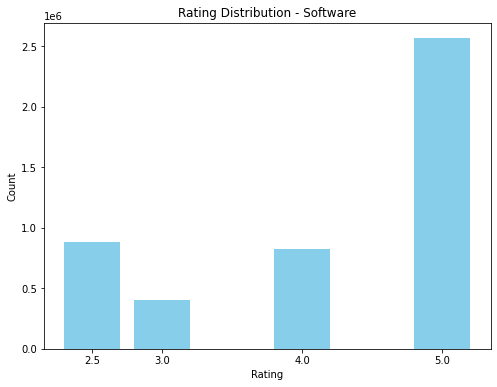

Displaying bar plot of categories...


main_category_numeric,count
0.0,4368657
3.0,299
2.0,6071
1.0,308685
4.0,49
6.0,5
5.0,8
8.0,1
7.0,2


Databricks visualization. Run in Databricks to view.

Displaying box plot of price...


price
2.0
0.0
0.0
0.0
0.99
0.0
0.0
0.99
0.0
0.0


Databricks visualization. Run in Databricks to view.

Displaying scatter plot of rating vs helpful_vote...


rating,helpful_vote
3.0,0.0
5.0,0.0
5.0,0.0
5.0,0.0
5.0,0.0
3.0,3.0
5.0,0.0
3.0,2.0
4.0,8.0
5.0,0.0


Databricks visualization. Run in Databricks to view.

Displaying pie chart of verified purchases...


verified_purchase_numeric,count
1,4474839
0,208938


Databricks visualization. Run in Databricks to view.

Displaying correlation matrix heatmap...


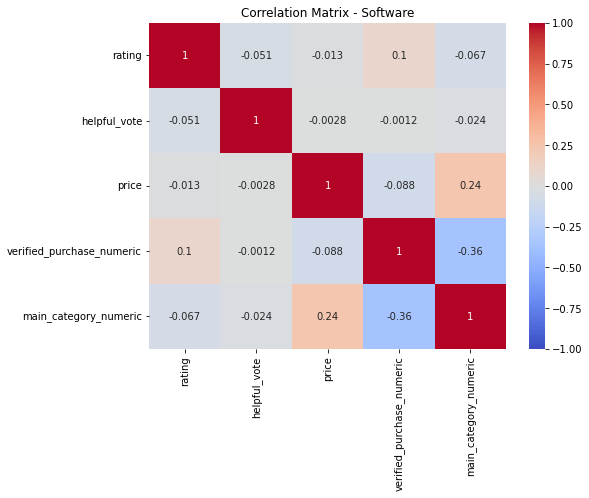


Performing feature analysis...
Identifying correlations between features...
Significant correlations (|correlation| > 0.5):
No significant correlations found.
Standardizing numerical features...
Tokenizing and vectorizing review_text...

Saving processed data...
Saved processed data to: dbfs:/FileStore/amazon_processed/Software
Saved CSV data to: dbfs:/FileStore/amazon_processed/Software_csv


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field scaled_numerical_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


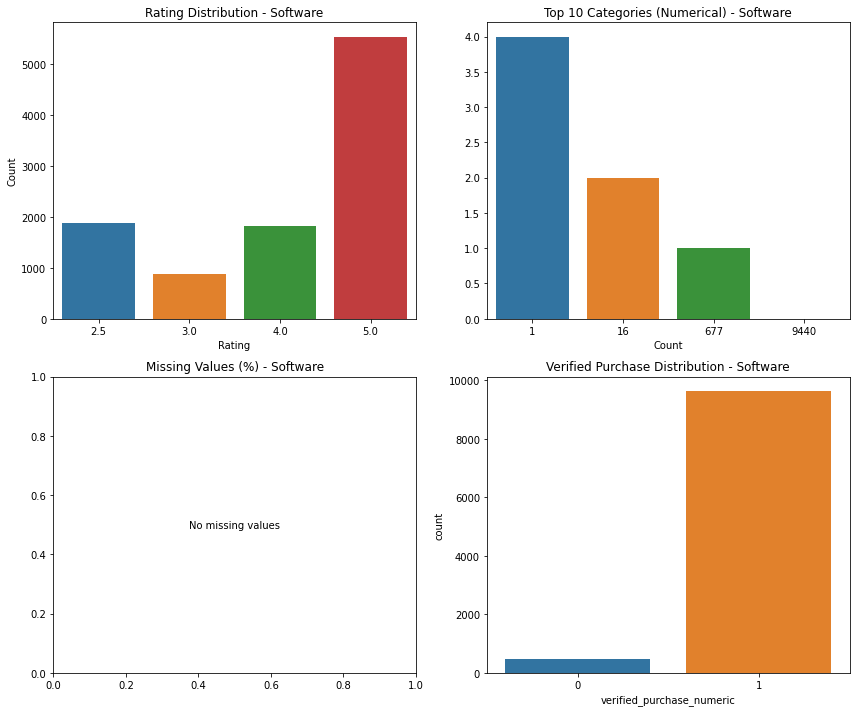


Sample of processed data:


product_id,parent_asin,user_id,rating,product_title,dataset,price,review_text,helpful_vote,verified_purchase_numeric,scaled_numerical_features,text_features,main_category_numeric
B004AHBBPW,B004AHBBPW,AE2VF4GF6OT66SDK4WAYIVXXTXOA,4.0,Daily Bible,Software,0.0,This has been easy to use and I enjoy the availability of the different reading plans. I also like the ability to change from one version to another as comparisons.,1.0,1,"Map(vectorType -> dense, length -> 5, values -> List(-0.1759344367192204, -0.27280392288455885, -0.10067499169783846, 0.21608268268465164, -0.2651696224981309))","Map(vectorType -> sparse, length -> 1000, indices -> List(17, 66, 105, 133, 166, 330, 372, 373, 387, 488, 495, 526, 532, 535, 681, 683, 713, 749, 756, 760, 792, 805, 815, 891, 921, 930), values -> List(3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0
B004AHBBPW,B004AHBBPW,AE5YT22LW3Z3FDLYH55F6FVECSVA,5.0,Daily Bible,Software,0.0,It is wonderful to have my daily verse as a widget on my phone and to receive a notification each day that there is a new verse. There are reading plans available ... great to have the Bible with me all the time.,0.0,1,"Map(vectorType -> dense, length -> 5, values -> List(0.810494605840073, -0.6350240131839616, -0.10067499169783846, 0.21608268268465164, -0.2651696224981309))","Map(vectorType -> sparse, length -> 1000, indices -> List(17, 102, 130, 133, 177, 209, 269, 276, 290, 299, 368, 369, 372, 467, 475, 488, 504, 526, 537, 568, 585, 617, 626, 650, 686, 714, 736, 749, 750, 760, 763, 881, 885, 891), values -> List(2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))",0.0
B004AHBBPW,B004AHBBPW,AH5AZ5Z5SHYQZWYUCOG66LJ4KU6A,5.0,Daily Bible,Software,0.0,This app I really enjoy. You can listen as well as read alone. Really look forward to using it for a long time. Good for Biblebeginners as well as long time Bible people.,0.0,1,"Map(vectorType -> dense, length -> 5, values -> List(0.810494605840073, -0.6350240131839616, -0.10067499169783846, 0.21608268268465164, -0.2651696224981309))","Map(vectorType -> sparse, length -> 1000, indices -> List(112, 133, 157, 166, 168, 276, 338, 344, 373, 411, 429, 467, 488, 506, 537, 547, 650, 686, 749, 756, 781, 847, 904, 925, 939, 960), values -> List(2.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0))",0.0
B004AHBBPW,B004AHBBPW,AHSABL64IXNJUHPA2V2YTLXF34IQ,4.0,Daily Bible,Software,0.0,"The app is great. My problem is that I have the font set fairly large. This works fine but when I need to choose a different book, chapter, verse -- the font is extremely small and going into settings does not give me a place to change this area. I use a Kindle Fire. I have asked this question through their web site but haven't gotten a response to solve this.",0.0,1,"Map(vectorType -> dense, length -> 5, values -> List(-0.1759344367192204, -0.6350240131839616, -0.10067499169783846, 0.21608268268465164, -0.2651696224981309))","Map(vectorType -> sparse, length -> 1000, indices -> List(17, 38, 51, 76, 102, 105, 133, 209, 222, 224, 280, 299, 342, 349, 353, 357, 369, 373, 385, 387, 390, 405, 424, 431, 445, 467, 488, 537, 568, 591, 597, 605, 622, 650, 683, 698, 706, 707, 713, 739, 756, 760, 776, 781, 783, 854, 891, 947, 963, 967, 994), values -> List(3.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0))",0.0
B004ANC00Q,B004ANC00Q,AGCA3XPPRMFOE237WT4J4SP5IZ5Q,3.0,Car Locator,Software,3.99,App glitches a bit. You have to remember to set it when you park and with 3 kids I can get distracted. It was hard to get my map back to car from walk

In [0]:
## 4. Main Execution

# Example usage (modify paths as needed for your Databricks environment)
reviews_path = "dbfs:/FileStore/amazon_processed/Software.jsonl"
metadata_path = "dbfs:/FileStore/amazon_processed/meta_Software.jsonl"
output_path = "dbfs:/FileStore/amazon_processed"
custom_include_timestamp = False

# Process the full dataset
results = process_dataset(
    reviews_path=reviews_path,
    metadata_path=metadata_path,
    output_path=output_path,
    include_timestamp=custom_include_timestamp
)

# Load the processed data for visualization
if "output_path" in results:
    processed_df = spark.read.parquet(results["output_path"])
    
    # Display data quality visualizations
    visualize_data_quality(processed_df, results["dataset"])
    
    # Display sample of the processed data
    print("\nSample of processed data:")
    display(processed_df.limit(10))

In [0]:
  ## 5. Advanced Data Cleaning (Optional)

def advanced_cleaning(df):
    """
    Perform advanced data cleaning operations
    
    Parameters:
    -----------
    df : DataFrame
        Spark DataFrame to clean
        
    Returns:
    --------
    DataFrame
        Cleaned DataFrame
    """
    # Make a copy to avoid modifying the original
    result_df = df
    
    # Clean text fields - remove special characters and extra whitespace
    if "review_text" in df.columns:
        result_df = result_df.withColumn(
            "review_text_clean", 
            regexp_replace(col("review_text"), "[^a-zA-Z0-9\\s]", " ")
        )
        result_df = result_df.withColumn(
            "review_text_clean", 
            regexp_replace(col("review_text_clean"), "\\s+", " ")
        )
    
    # Convert price to numeric (if exists)
    if "price" in df.columns:
        # First check if it's already numeric
        if str(df.schema["price"].dataType) == "StringType":
            # Remove currency symbol and convert to double
            result_df = result_df.withColumn(
                "price_numeric", 
                regexp_replace(col("price"), "[$,]", "").cast(DoubleType())
            )
        else:
            # Already numeric, just rename
            result_df = result_df.withColumn("price_numeric", col("price"))
    
    # Normalize rating to 0-1 scale (for ML)
    if "rating" in df.columns:
        result_df = result_df.withColumn(
            "rating_normalized", 
            col("rating") / 5.0
        )
    
    return result_df

In [0]:
## 6. Saving Processing Summary

def save_processing_summary(results, output_path):
    """
    Save processing summary as a text file
    
    Parameters:
    -----------
    results : dict
        Processing results
    output_path : str
        Path to save summary
    """
    summary_text = f"""
Amazon Review Data Processing Summary
====================================

Processing completed for dataset: {results.get('dataset', 'Unknown')}
Status: {results.get('status', 'Unknown')}

Statistics:
- Categories: {results.get('categories', 'N/A')}
- Total records: {results.get('total_records', 'N/A')}
- Output path: {results.get('output_path', 'N/A')}

Processing Parameters:
- Included timestamp: {DEFAULT_INCLUDE_TIMESTAMP}

Insights:
{chr(10).join([f"- {insight}" for insight in results.get('insights', [])])}

This summary was generated automatically by the Amazon Review Data Processor.
    """
    
    # Convert to Spark DataFrame
    summary_df = spark.createDataFrame([(summary_text,)], ["summary"])
    
    # Save as text file
    summary_path = f"{output_path}/processing_summary.txt"
    summary_df.write.mode("overwrite").text(summary_path)
    print(f"Saved processing summary to: {summary_path}")

In [0]:
## Create downloadable file links
files_to_download = []
html_links = []

# Create a single consolidated CSV file
dataset_name = os.path.basename(reviews_path).split('.')[0]
csv_df = spark.read.parquet(f"{output_path}/{dataset_name}")

# Convert vector columns to strings
if "scaled_numerical_features" in csv_df.columns:
    csv_df = csv_df.withColumn(
        "scaled_numerical_features", 
        col("scaled_numerical_features").cast("string")
    )
if "text_features" in csv_df.columns:
    csv_df = csv_df.withColumn(
        "text_features", 
        col("text_features").cast("string")
    )

single_csv_path = f"{output_path}/{dataset_name}_single.csv"
csv_df.coalesce(1).write.mode("overwrite").option("header", "true").csv(single_csv_path)

# Find the CSV file
csv_files = dbutils.fs.ls(single_csv_path)
csv_part_files = [file.path for file in csv_files if file.name.endswith(".csv") and file.name.startswith("part-")]
if csv_part_files:
    files_to_download.append(("csv", csv_part_files[0], f"{dataset_name}_data.csv"))

# Copy to FileStore downloads folder and create download link
for file_type, source_path, target_name in files_to_download:
    download_path = f"/FileStore/downloads/{target_name}"
    dbutils.fs.cp(source_path, download_path)
    link_text = f"Download {dataset_name} {file_type.upper()} File"
    html_links.append(f'<a href="/files/downloads/{target_name}" target="_blank">{link_text}</a>')